# Differential Quantum Circuits (DQCs)

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from qadence import feature_map, hea, chain
from qadence import QNN, QuantumCircuit, Z, ising_hamiltonian
from qadence.types import BasisSet, ReuploadScaling
from qadence import add

In [72]:
torch.manual_seed(404)
# Parameters
lam = 8
k = 0.1
n_qubits = 6
depth = 5

In [73]:
def dfdx_equation(x: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    x_np = x.detach().numpy()
    f_np = f.detach().numpy()
    result_np = -lam * f_np * (k + np.tan(lam * x_np))
    return torch.tensor(result_np)

def f_exact(x: torch.Tensor) -> torch.Tensor:
    x_np = x.detach().numpy()
    result = np.exp(-k * lam * x_np) * np.cos(lam * x_np)
    return torch.tensor(result)

In [74]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad

In [75]:
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs, model_output)
    norm_deriv_model = deriv_model / torch.norm(deriv_model)
    norm_deriv_exact = deriv_exact / torch.norm(deriv_exact)
    ode_loss = criterion(norm_deriv_model, norm_deriv_exact)

    boundary_model = model(torch.tensor([[0.0]], requires_grad=True))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)

    return 0.9*ode_loss + 0.1* boundary_loss

In [76]:
from qadence import RX,RZ
# Feature map
fm = feature_map(
    n_qubits=n_qubits,
    param="x",
    fm_type=BasisSet.CHEBYSHEV,
    reupload_scaling=ReuploadScaling.TOWER,
)

# Ansatz
ansatz = hea(n_qubits=n_qubits, depth=depth, operations=[RZ,RX,RZ])

# Observable
observable = ising_hamiltonian(n_qubits=n_qubits)

# Quantum Circuit
circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
model = QNN(circuit=circuit, observable=observable, inputs=["x"])

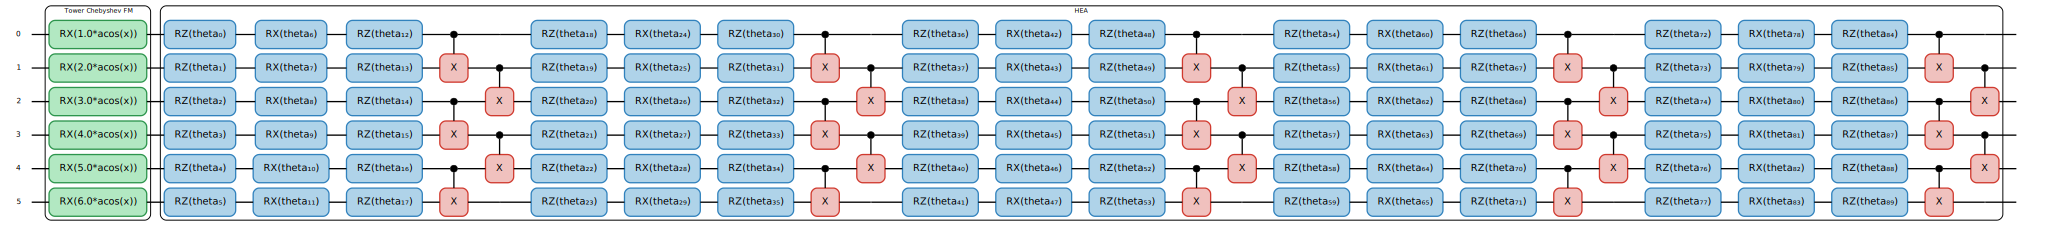

In [77]:
from qadence.draw import display

display(circuit)

In [78]:
# Training parameters
n_epochs = 2000
n_points = 50
xmin, xmax = 0, 1

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

for epoch in range(n_epochs+1):
    optimizer.zero_grad()

    x_train = (xmin + (xmax - xmin) * torch.rand(n_points, requires_grad=True)).unsqueeze(1)
    loss = loss_fn(inputs=x_train, model=model)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item()}")

Epoch 0/2000, Loss: 0.15373083543419824
Epoch 100/2000, Loss: 0.04159445840633763
Epoch 200/2000, Loss: 0.02506010691516731
Epoch 300/2000, Loss: 0.014085115985463931
Epoch 400/2000, Loss: 0.016839704798406293
Epoch 500/2000, Loss: 0.01733139911436126
Epoch 600/2000, Loss: 0.004670413861926901
Epoch 700/2000, Loss: 0.0018605399068110878
Epoch 800/2000, Loss: 0.00603691195478691
Epoch 900/2000, Loss: 0.012075183496805676
Epoch 1000/2000, Loss: 0.021466666438722998
Epoch 1100/2000, Loss: 0.022728792413003206
Epoch 1200/2000, Loss: 0.026918361715518077
Epoch 1300/2000, Loss: 0.017786971230489883
Epoch 1400/2000, Loss: 0.018327190585349117
Epoch 1500/2000, Loss: 0.011537062093601452
Epoch 1600/2000, Loss: 0.027253757209229405
Epoch 1700/2000, Loss: 0.008609245603214143
Epoch 1800/2000, Loss: 0.027053021378296495
Epoch 1900/2000, Loss: 0.0246467500573423
Epoch 2000/2000, Loss: 0.0018823655584580543


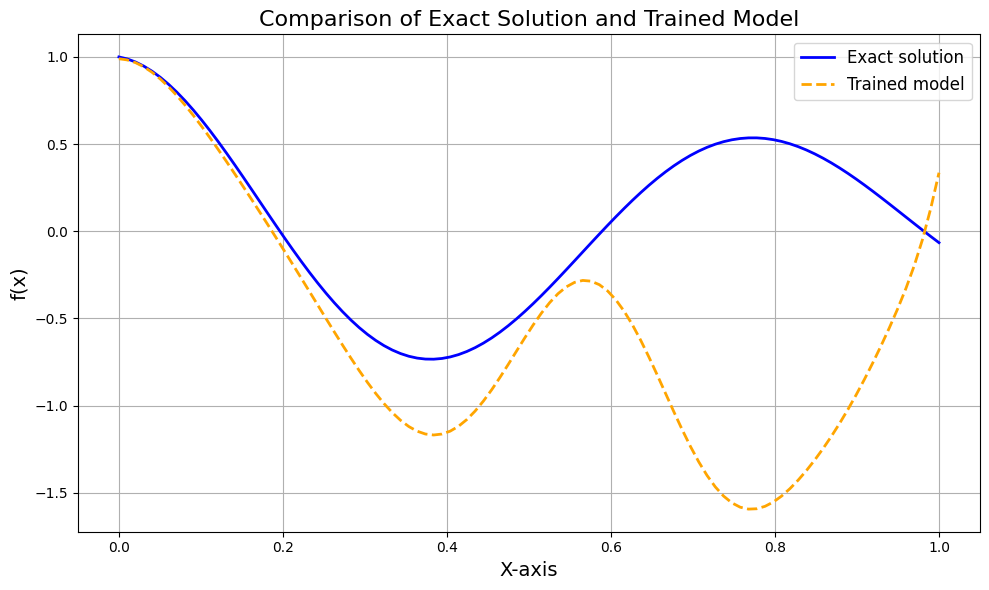

In [79]:
# Testing and plotting
x_test = torch.linspace(xmin, xmax, steps=100).unsqueeze(1)
result_exact = f_exact(x_test).flatten()
result_model = model(x_test).flatten().detach()

plt.figure(figsize=(10, 6))
plt.plot(x_test, result_exact, label="Exact solution", color='blue', linestyle='-', linewidth=2)
plt.plot(x_test, result_model, label="Trained model", color='orange', linestyle='--', linewidth=2)
plt.title("Comparison of Exact Solution and Trained Model", fontsize=16)
plt.xlabel("X-axis", fontsize=14)
plt.ylabel("f(x)", fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
